 **変数の意味**

- hand : トランプカード5枚からなるひとつの手札

- NUM_SUIT : カードのスートの数（4）

- NUM_RANK : カードの数字の数（13）


In [101]:
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import time
from keras.utils.np_utils import to_categorical

random_seed = 0
np.random.seed(random_seed)

### 必要な関数の定義

In [102]:
NUM_SUIT = 4
NUM_RANK = 13

def is_one_pair(hand):
    sum_hand = np.sum(hand, axis=0)
    #print(sum_hand.max())
    if sum_hand.max() >= 2:
        return True
    else:
        return False
    
def is_two_pair(hand):
    sum_hand = np.sum(hand, axis=0)
    #print(len(sum_hand[sum_hand >= 2]))
    if len(sum_hand[sum_hand >= 2]) == 2:
        return True
    else:
        return False
    
def is_three_of_a_kind(hand):
    sum_hand = np.sum(hand, axis=0)
    if sum_hand.max() >= 3:
        return True
    else:
        return False
    
def is_straight(hand):
    sum_hand = np.sum(hand, axis=0)
    for i in range(NUM_RANK - 4):
        slice_hand = sum_hand[i:i+5]
        #print(sum_hand[i:i+5])
        #print(slice_hand[slice_hand > 0])
        if (slice_hand.sum() == 5 and len(slice_hand[slice_hand > 0]) == 5):
            return True
    if sum_hand[0] == sum_hand[9] == sum_hand[10] == sum_hand[11] == sum_hand[12] == 1:
        return True
    return False
        
def is_flush(hand):
    sum_hand = np.sum(hand, axis=1)
    if sum_hand.max() == 5:
        return True
    else:
        return False
    
def is_full_house(hand):
    sum_hand = np.sum(hand, axis=0)
    #print(sum_hand[sum_hand >= 2])
    if len(sum_hand[sum_hand >= 2]) == 2 and sum_hand.max() == 3:
        return True
    else:
        return False
    
def is_four_of_a_kind(hand):
    sum_hand = np.sum(hand, axis=0)
    if sum_hand.max() == 4:
        return True
    else:
        return False
    
def is_straight_flush(hand):
    return is_flush(hand) and is_straight(hand)

In [103]:
# 上の関数が正しいかどうかのテスト

import unittest
hand0 = np.zeros((NUM_SUIT, NUM_RANK))
hand0[0][0] = 1
hand0[0][1] = 1
hand0[1][1] = 1
hand0[2][0] = 1
hand0[3][10] = 1
hand1 = np.zeros((NUM_SUIT, NUM_RANK))
hand1[0][0] = 1
hand1[0][1] = 1
hand1[0][2] = 1
hand1[0][3] = 1
hand1[1][0] = 1
hand2 = np.zeros((NUM_SUIT, NUM_RANK))
hand2[3][0] = 1
hand2[3][9] = 1
hand2[3][10] = 1
hand2[3][11] = 1
hand2[3][12] = 1
hand3 = np.zeros((NUM_SUIT, NUM_RANK))
hand3[3][0] = 1
hand3[2][0] = 1
hand3[0][5] = 1
hand3[2][5] = 1
hand3[3][5] = 1
hand4 = np.zeros((NUM_SUIT, NUM_RANK))
hand4[3][10] = 1
hand4[2][10] = 1
hand4[0][10] = 1
hand4[1][10] = 1
hand4[3][5] = 1
print(hand0)
print(hand1)
print(hand2)
print(hand3)
print(hand4)

class TestIsHand(unittest.TestCase):
    def test_hand(self):
        self.assertTrue(is_one_pair(hand0))
        self.assertTrue(is_one_pair(hand1))
        self.assertFalse(is_one_pair(hand2))
        self.assertTrue(is_one_pair(hand3))
        self.assertTrue(is_one_pair(hand4))
        
        self.assertTrue(is_two_pair(hand0))
        self.assertFalse(is_two_pair(hand1))
        self.assertFalse(is_two_pair(hand2))
        self.assertTrue(is_two_pair(hand3))
        self.assertFalse(is_two_pair(hand4))
        
        self.assertFalse(is_three_of_a_kind(hand0))
        self.assertFalse(is_three_of_a_kind(hand1))
        self.assertFalse(is_three_of_a_kind(hand2))
        self.assertTrue(is_three_of_a_kind(hand3))
        self.assertTrue(is_three_of_a_kind(hand4))
        
        self.assertFalse(is_straight(hand0))
        self.assertFalse(is_straight(hand1))
        self.assertTrue(is_straight(hand2))
        self.assertFalse(is_straight(hand3))
        self.assertFalse(is_straight(hand4))
        
        self.assertFalse(is_flush(hand0))
        self.assertFalse(is_flush(hand1))
        self.assertTrue(is_flush(hand2))
        self.assertFalse(is_flush(hand3))
        self.assertFalse(is_flush(hand4))
        
        self.assertFalse(is_full_house(hand0))
        self.assertFalse(is_full_house(hand1))
        self.assertFalse(is_full_house(hand2))
        self.assertTrue(is_full_house(hand3))
        self.assertFalse(is_full_house(hand4))
        
        self.assertFalse(is_four_of_a_kind(hand0))
        self.assertFalse(is_four_of_a_kind(hand1))
        self.assertFalse(is_four_of_a_kind(hand2))
        self.assertFalse(is_four_of_a_kind(hand3))
        self.assertTrue(is_four_of_a_kind(hand4))
        
        self.assertFalse(is_straight_flush(hand0))
        self.assertFalse(is_straight_flush(hand1))
        self.assertTrue(is_straight_flush(hand2))
        self.assertFalse(is_straight_flush(hand3))
        self.assertFalse(is_straight_flush(hand4))
        
suite = unittest.TestSuite()
suite.addTest(TestIsHand('test_hand'))
runner = unittest.TextTestRunner()
runner.run(suite)

.

[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]]



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### 教師データの作成

In [104]:
# それぞれnumの数だけhandを生成する。ただしone_pairは成立する例が多いので作らない。

def make_random(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]        
        count = 0
        while(count < 5):
            rand_i = random.randrange(NUM_SUIT)
            rand_j = random.randrange(NUM_RANK)
            if hand[rand_i][rand_j] == 0:
                hand[rand_i][rand_j] = 1
                count += 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_two_pair(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]
        count = 0
        while(count < 2):            
            rand_i = random.randrange(NUM_SUIT - 1)
            rand_j = random.randrange(NUM_RANK)
            if hand[rand_i][rand_j] == 0 and hand[rand_i + 1][rand_j] == 0:
                hand[rand_i][rand_j] = 1
                hand[rand_i + 1][rand_j] = 1
                count += 1
        while(True):
            rand_i = random.randrange(NUM_SUIT)
            rand_j = random.randrange(NUM_RANK)
            if hand[rand_i][rand_j] == 0:
                hand[rand_i][rand_j] = 1
                break
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_three_of_a_kind(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]
        rand_i = random.randrange(NUM_SUIT - 2)
        rand_j = random.randrange(NUM_RANK)
        hand[rand_i][rand_j] = 1
        hand[rand_i + 1][rand_j] = 1
        hand[rand_i + 2][rand_j] = 1
        count = 0
        while(count < 2):
            rand_i = random.randrange(NUM_SUIT)
            rand_j = random.randrange(NUM_RANK)
            if hand[rand_i][rand_j] == 0:
                hand[rand_i][rand_j] = 1
                count += 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_straight(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]
        rand_j = random.randrange(NUM_RANK - 5)
        for i in range(5):
            rand_i = random.randrange(NUM_SUIT)
            hand[rand_i][rand_j + i] = 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_flush(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]
        rand_i = random.randrange(NUM_SUIT)
        count = 0
        while(count < 5):
            rand_j = random.randrange(NUM_RANK)
            if hand[rand_i][rand_j] == 0:
                hand[rand_i][rand_j] = 1
                count += 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_full_house(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]        
        rand_i = random.randrange(NUM_SUIT - 2)
        rand_j = random.randrange(NUM_RANK)
        hand[rand_i][rand_j] = 1
        hand[rand_i + 1][rand_j] = 1
        hand[rand_i + 2][rand_j] = 1
        while(True):
            rand_j2 = random.randrange(NUM_RANK)
            if rand_j == rand_j2:
                continue
            break
        rand_i = random.randrange(NUM_SUIT - 1)
        hand[rand_i][rand_j2] = 1
        hand[rand_i + 1][rand_j2] = 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_four_of_a_kind(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]        
        rand_j = random.randrange(NUM_RANK)
        hand[0][rand_j] = 1
        hand[1][rand_j] = 1
        hand[2][rand_j] = 1
        hand[3][rand_j] = 1
        while(True):
            rand_j2 = random.randrange(NUM_RANK)
            if rand_j == rand_j2:
                continue
            break
        rand_i = random.randrange(NUM_SUIT)
        hand[rand_i][rand_j2] = 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_straight_flush(num):
    hand_list = []
    for n in range(num):
        hand = [[0 for i in range(NUM_RANK)] for j in range(NUM_SUIT)]        
        count = 0
        rand_i = random.randrange(NUM_SUIT)
        rand_j = random.randrange(NUM_RANK - 4)
        hand[rand_i][rand_j] = 1
        hand[rand_i][rand_j + 1] = 1
        hand[rand_i][rand_j + 2] = 1
        hand[rand_i][rand_j + 3] = 1
        hand[rand_i][rand_j + 4] = 1
        #print(np.array(hand))
        hand_list.append(hand)
    return hand_list

def make_hand_list(num):
    hand_list = []
    hand_list += make_random(int(num / 8))
    hand_list += make_two_pair(int(num / 8))
    hand_list += make_three_of_a_kind(int(num / 8))
    hand_list += make_straight(int(num / 8))
    hand_list += make_flush(int(num / 8))
    hand_list += make_full_house(int(num / 8))
    hand_list += make_four_of_a_kind(int(num / 8))
    hand_list += make_straight_flush(int(num / 8))
    return hand_list

In [105]:
# データの作成時のみ動かす

num = 200000
hand_list = make_hand_list(num)
is_hand_list = []
for hand in hand_list:
    train = []
    if is_one_pair(hand):
        train.append(True)
    else:
        train.append(False)
    if is_two_pair(hand):
        train.append(True)
    else:
        train.append(False)
    if is_three_of_a_kind(hand):
        train.append(True)
    else:
        train.append(False)
    if is_straight(hand):
        train.append(True)
    else:
        train.append(False)
    if is_flush(hand):
        train.append(True)
    else:
        train.append(False)
    if is_full_house(hand):
        train.append(True)
    else:
        train.append(False)
    if is_four_of_a_kind(hand):
        train.append(True)
    else:
        train.append(False)
    if is_straight_flush(hand):
        train.append(True)
    else:
        train.append(False)
    #print(train)
    is_hand_list.append(train)

np.save('data/hand_list_{}'.format(num), np.array(hand_list))
np.save('data/is_hand_list_{}'.format(num), np.array(is_hand_list))

In [73]:
num = 1000000
y_path = np.load('data/is_hand_list_{}.npy'.format(num))
x_path = np.load('data/hand_list_{}.npy'.format(num))
# y_path.shape
is_onepair = y_path[:,0]
is_twopair = y_path[:,1]
is_three = y_path[:,2]
is_straight = y_path[:,3]
is_flush = y_path[:,4]
is_full = y_path[:,5]
is_four = y_path[:,6]
is_sf = y_path[:,7]

# for i in range(950, 960):
#     print(x_path[i], is_onepair[i], is_twopair[i], is_three[i], is_straight[i], is_flush[i], is_full[i], is_four[i], is_sf[i])

np.save('data/is_one_pair_{}'.format(num), is_onepair)
np.save('data/is_two_pair_{}'.format(num), is_twopair)
np.save('data/is_three_of_a_kind_{}'.format(num), is_three)
np.save('data/is_straight_{}'.format(num), is_straight)
np.save('data/is_flush_{}'.format(num), is_flush)
np.save('data/is_full_house_{}'.format(num), is_full)
np.save('data/is_four_of_a_kind_{}'.format(num), is_four)
np.save('data/is_straight_flush_{}'.format(num), is_sf)

In [36]:
x_path = np.load('data/hand_list_1000.npy').tolist()
print(np.load('data/hand_list_1000.npy').shape)
y_path = np.load('data/is_hand_list_1000.npy').tolist()
len(y_path)

(1000, 4, 13)


1000

### 教師あり学習

In [106]:
from keras import layers
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.models import load_model

def dense_train_all(NUM_SUIT, NUM_RANK, epochs, x_path, y_path):
    input_shape = (NUM_SUIT, NUM_RANK)
    print(input_shape)
    
    # モデルの定義
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    #model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(8))
    model.summary()
    
#     model = models.Sequential()
#     model.add(layers.Conv1D(filters=256, kernel_size=3, padding='same', data_format='channels_first', input_shape=input_shape))
#     model.add(layers.Conv1D(filters=256, kernel_size=3, padding='same', data_format='channels_first'))
#     model.add(layers.Conv1D(filters=128, kernel_size=3, padding='same', data_format='channels_first'))
#     model.add(layers.Conv1D(filters=128, kernel_size=3, padding='same', data_format='channels_first'))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(8))
#     model.summary()

    'binary_crossentropy'
    'categorical_crossentropy'
    'mse'
    'mean_absolute_error'
    
    # モデルのコンパイル
    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    # 学習データの読み込み
    x = np.load(x_path)
    y = np.load(y_path)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_seed)

    history = model.fit(x = x_train,
                        y = y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test), 
                       )

    # モデルの保存
    #model.save('models/poker_hand_{}.h5'.format(num_hand))
    return history

def draw_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)

    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.plot(epochs, acc, 'bo', label='Training acc')
    fig1.plot(epochs, val_acc, 'b', label='Validation acc')

    fig1.set_xlabel('epochs')
    fig1.set_ylabel('accuracy')
    fig.legend(bbox_to_anchor=(0., 0.19, 0.86, 0.102), loc=5)# anchor（凡例）の第２引数がx、第３引数がy

    #fig.savefig('draw_pdf/poker_acc_{}_{}epo.pdf'.format(num_hand, len(acc)))
    plt.show()
    
def draw_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    fig = plt.figure()
    fig1 = fig.add_subplot(111)
    fig1.plot(epochs, loss, 'bo', label='Training loss')
    fig1.plot(epochs, val_loss, 'b', label='Validation loss')
    #fig1.title('Training and validation loss')

    fig1.set_xlabel('epochs')
    fig1.set_ylabel('loss')
    fig.legend(bbox_to_anchor=(0., 0.73, 0.86, 0.102), loc=5) # anchor（凡例）の第２引数がy、第３引数がx

    #fig.savefig('draw_pdf/loss_{}_{}epo.pdf'.format(num_hand, len(loss)))
    plt.show()

In [117]:
def dense_train_one64(NUM_SUIT, NUM_RANK, epochs, x_path, y_path):
    input_shape = (NUM_SUIT, NUM_RANK)
    print(input_shape)
    
    # モデルの定義
#     model = models.Sequential()
#     model.add(layers.Flatten(input_shape=input_shape))
#     #model.add(layers.Dense(1024, activation='relu'))
#     model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(1))
#     model.summary()
    
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first', input_shape=input_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    'binary_crossentropy'
    'categorical_crossentropy'
    'mse'

    # モデルのコンパイル
    model.compile(loss='mse',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    # 学習データの読み込み
    x = np.load(x_path)
    y = np.load(y_path)
#     y = to_categorical(y, num_classes=2)
    #print(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_seed)

    history = model.fit(x = x_train,
                        y = y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test), 
                       )

    # モデルの保存
    #model.save('models/poker_hand_{}.h5'.format(num_hand))
    return history

In [118]:
def dense_train_one128(NUM_SUIT, NUM_RANK, epochs, x_path, y_path):
    input_shape = (NUM_SUIT, NUM_RANK)
    print(input_shape)
    
    # モデルの定義
#     model = models.Sequential()
#     model.add(layers.Flatten(input_shape=input_shape))
#     #model.add(layers.Dense(1024, activation='relu'))
#     model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(1))
#     model.summary()
    
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first', input_shape=input_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    'binary_crossentropy'
    'categorical_crossentropy'
    'mse'

    # モデルのコンパイル
    model.compile(loss='mse',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    # 学習データの読み込み
    x = np.load(x_path)
    y = np.load(y_path)
#     y = to_categorical(y, num_classes=2)
    #print(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_seed)

    history = model.fit(x = x_train,
                        y = y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test), 
                       )

    # モデルの保存
    #model.save('models/poker_hand_{}.h5'.format(num_hand))
    return history

In [119]:
def dense_train_one256(NUM_SUIT, NUM_RANK, epochs, x_path, y_path):
    input_shape = (NUM_SUIT, NUM_RANK)
    print(input_shape)
    
    # モデルの定義
#     model = models.Sequential()
#     model.add(layers.Flatten(input_shape=input_shape))
#     #model.add(layers.Dense(1024, activation='relu'))
#     model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(1))
#     model.summary()
    
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first', input_shape=input_shape))
    model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    'binary_crossentropy'
    'categorical_crossentropy'
    'mse'

    # モデルのコンパイル
    model.compile(loss='mse',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])

    # 学習データの読み込み
    x = np.load(x_path)
    y = np.load(y_path)
#     y = to_categorical(y, num_classes=2)
    #print(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_seed)

    history = model.fit(x = x_train,
                        y = y_train,
                        epochs = epochs,
                        validation_data = (x_test, y_test), 
                       )

    # モデルの保存
    #model.save('models/poker_hand_{}.h5'.format(num_hand))
    return history

(4, 13)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 52)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 512)               27136     
_________________________________________________________________
dense_60 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_61 (Dense)             (None, 8)                 1032      
Total params: 93,832
Trainable params: 93,832
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/3
140000/140000 [==============================] - 15s 106us/step - loss: 0.1613 - acc: 0.5635 - val_loss: 0.0589 - val_acc: 0.3606
Epoch 2/3
140000/140000 [=======================

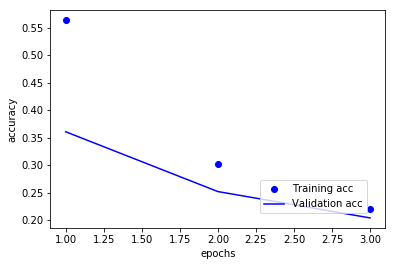

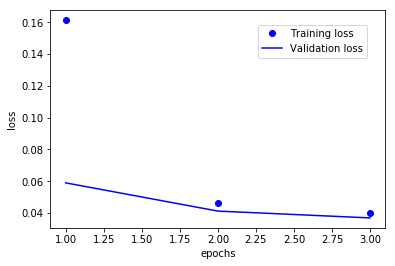

In [44]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_hand_list_{}.npy'.format(num_hand)
history = dense_train_all(NUM_SUIT, NUM_RANK, 3, x_path, y_path)
draw_acc(history)
draw_loss(history)
# binary

(4, 13)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 256, 13)           3328      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 256, 13)           196864    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 128, 13)           98432     
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 128, 13)           49280     
_________________________________________________________________
flatten_24 (Flatten)         (None, 1664)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               213120    
_________________________________________________________________
dense_66 (Dense)             (None, 64)      

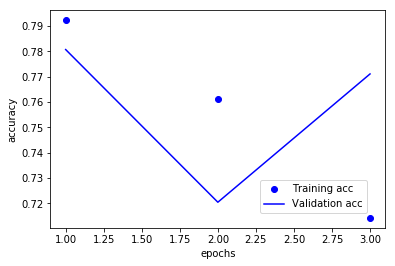

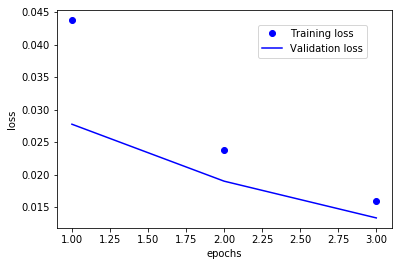

In [48]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_hand_list_{}.npy'.format(num_hand)
history = dense_train_all(NUM_SUIT, NUM_RANK, 3, x_path, y_path)
draw_acc(history)
draw_loss(history)
# mse

(4, 13)
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_43 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

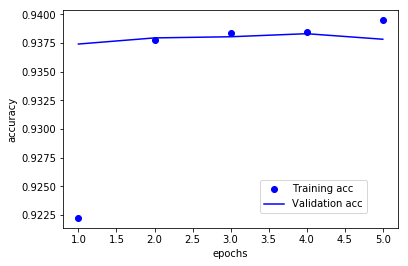

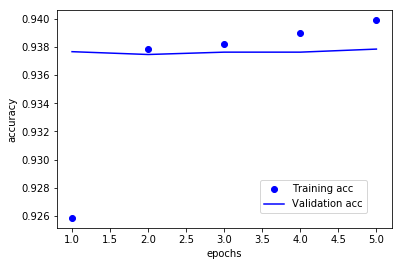

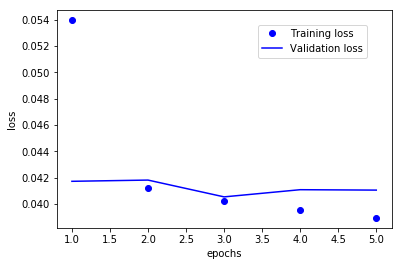

In [120]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_one_pair_{}.npy'.format(num_hand)
history_one_pair64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_one_pair128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_one_pair256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_one_pair64)
draw_acc(history_one_pair128)
draw_loss(history_one_pair256)
# mse

(4, 13)
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_53 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

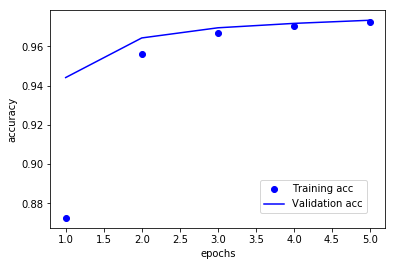

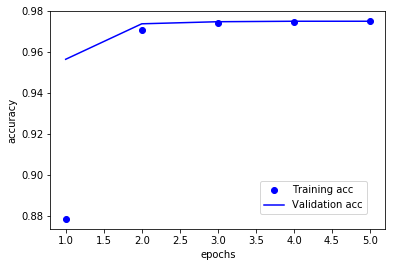

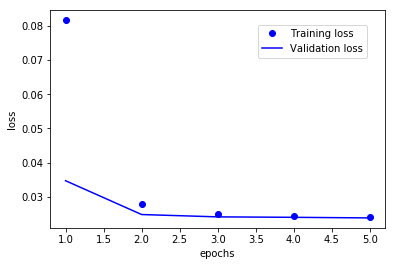

In [128]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_two_pair_{}.npy'.format(num_hand)
history_two_pair64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_two_pair128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_two_pair256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_two_pair64)
draw_acc(history_two_pair128)
draw_loss(history_two_pair256)

(4, 13)
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_56 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

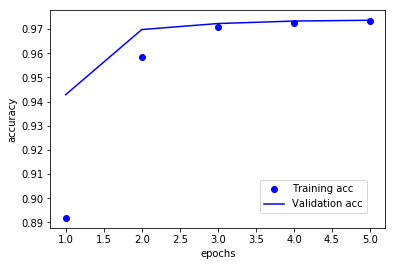

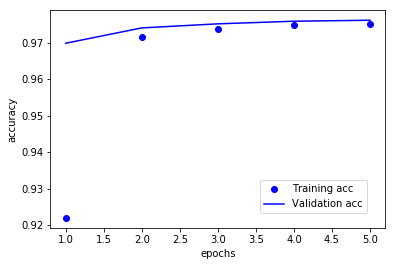

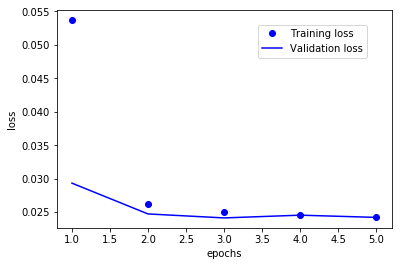

In [129]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_three_of_a_kind_{}.npy'.format(num_hand)
history_three64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_three128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_three256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_three64)
draw_acc(history_three128)
draw_loss(history_three256)

(4, 13)
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_59 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_152 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

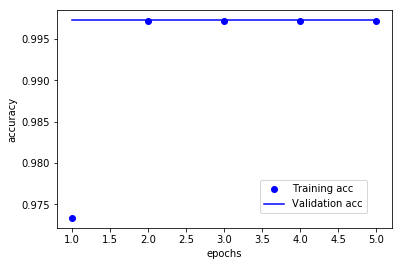

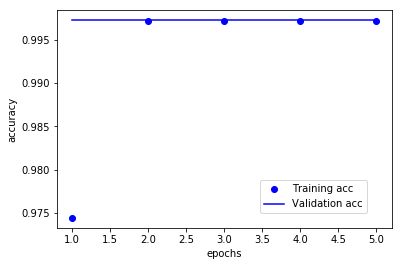

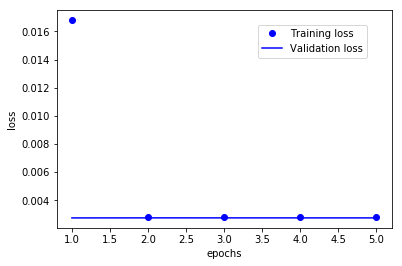

In [130]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_straight_{}.npy'.format(num_hand)
history_straight64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_straight128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_straight256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_straight64)
draw_acc(history_straight128)
draw_loss(history_straight256)

(4, 13)
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_85 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_86 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_62 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

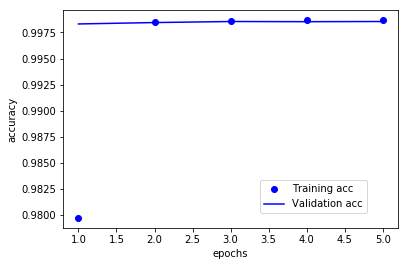

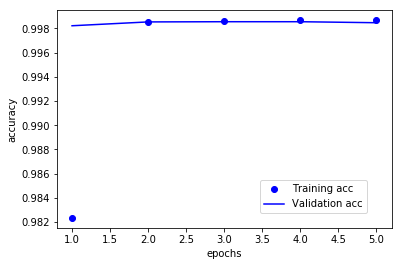

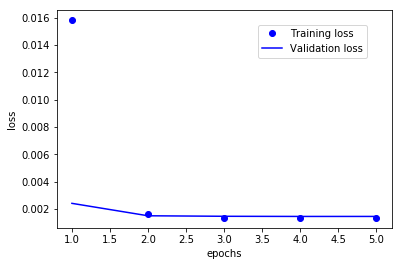

In [131]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_flush_{}.npy'.format(num_hand)
history_flush64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_flush128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_flush256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_flush64)
draw_acc(history_flush128)
draw_loss(history_flush256)

(4, 13)
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_65 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

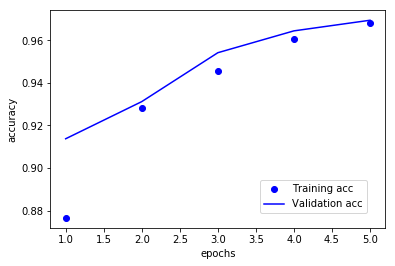

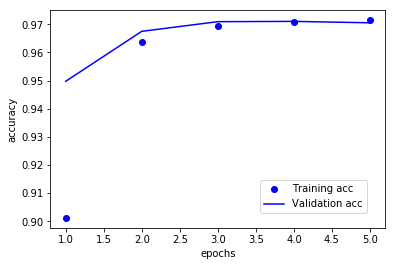

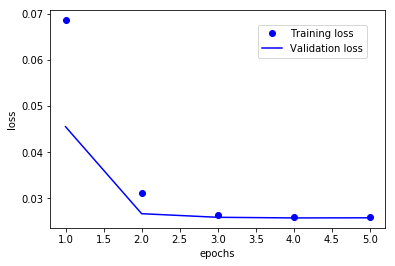

In [132]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_full_house_{}.npy'.format(num_hand)
history_full64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_full128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_full256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_full64)
draw_acc(history_full128)
draw_loss(history_full256)

(4, 13)
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_97 (Conv1D)           (None, 64, 13)            832       
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 64, 13)            12352     
_________________________________________________________________
flatten_68 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

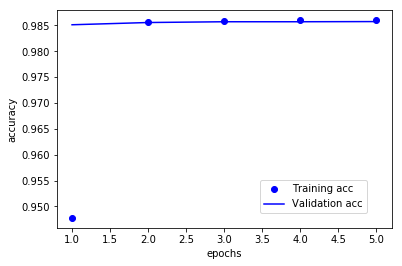

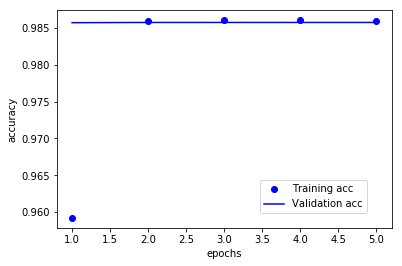

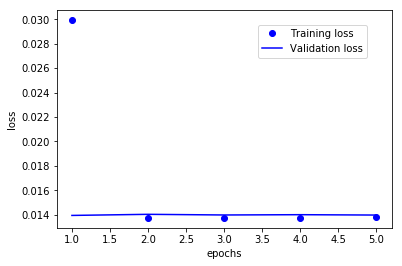

In [133]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_four_of_a_kind_{}.npy'.format(num_hand)
history_four64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_four128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_four256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_four64)
draw_acc(history_four128)
draw_loss(history_four256)

(4, 13)
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_109 (Conv1D)          (None, 64, 13)            832       
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 64, 13)            12352     
_________________________________________________________________
flatten_74 (Flatten)         (None, 832)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 64)                53312     
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 65        
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________
Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================]

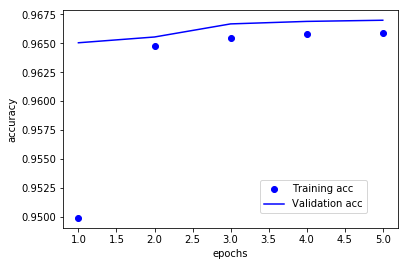

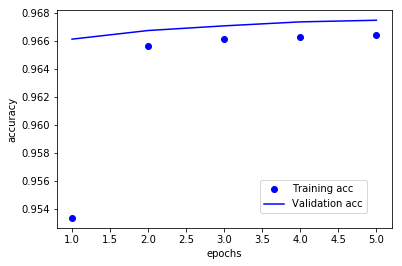

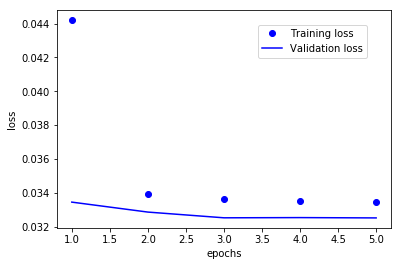

In [156]:
num_hand = 200000
x_path = 'data/hand_list_{}.npy'.format(num_hand)
y_path = 'data/is_straight_flush_{}.npy'.format(num_hand)
history_sf64 = dense_train_one64(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_sf128 = dense_train_one128(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
history_sf256 = dense_train_one256(NUM_SUIT, NUM_RANK, 5, x_path, y_path)
draw_acc(history_sf64)
draw_acc(history_sf128)
draw_loss(history_sf256)

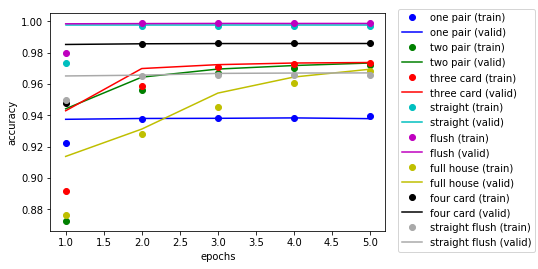

In [160]:
fig = plt.figure()
fig1 = fig.add_subplot(111)

acc = history_one_pair64.history['acc']
val_acc = history_one_pair64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'bo', label='one pair (train)')
fig1.plot(epochs, val_acc, 'b', label='one pair (valid)')


acc = history_two_pair64.history['acc']
val_acc = history_two_pair64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'go', label='two pair (train)')
fig1.plot(epochs, val_acc, 'g', label='two pair (valid)')

acc = history_three64.history['acc']
val_acc = history_three64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'ro', label='three card (train)')
fig1.plot(epochs, val_acc, 'r', label='three card (valid)')

acc = history_straight64.history['acc']
val_acc = history_straight64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'co', label='straight (train)')
fig1.plot(epochs, val_acc, 'c', label='straight (valid)')

acc = history_flush64.history['acc']
val_acc = history_flush64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'mo', label='flush (train)')
fig1.plot(epochs, val_acc, 'm', label='flush (valid)')

acc = history_full64.history['acc']
val_acc = history_full64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'yo', label='full house (train)')
fig1.plot(epochs, val_acc, 'y', label='full house (valid)')

acc = history_four64.history['acc']
val_acc = history_four64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'ko', label='four card (train)')
fig1.plot(epochs, val_acc, 'k', label='four card (valid)')

acc = history_sf64.history['acc']
val_acc = history_sf64.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, color='darkgray', linewidth=0, marker='o', label='straight flush (train)')
fig1.plot(epochs, val_acc, color='darkgray', label='straight flush (valid)')




fig1.set_xlabel('epochs')
fig1.set_ylabel('accuracy')
fig.legend(bbox_to_anchor=(0., 0.43, 1.25, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

fig.savefig('draw_pdf/poker64_acc_{}_{}epo.pdf'.format(num_hand, len(acc)))
plt.show()

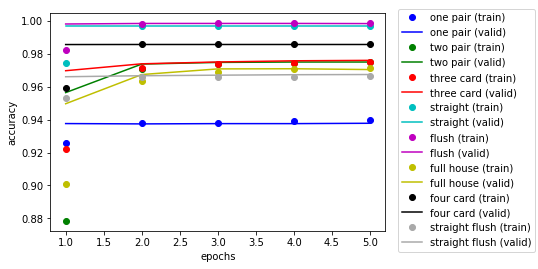

In [161]:
fig = plt.figure()
fig1 = fig.add_subplot(111)

acc = history_one_pair128.history['acc']
val_acc = history_one_pair128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'bo', label='one pair (train)')
fig1.plot(epochs, val_acc, 'b', label='one pair (valid)')


acc = history_two_pair128.history['acc']
val_acc = history_two_pair128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'go', label='two pair (train)')
fig1.plot(epochs, val_acc, 'g', label='two pair (valid)')

acc = history_three128.history['acc']
val_acc = history_three128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'ro', label='three card (train)')
fig1.plot(epochs, val_acc, 'r', label='three card (valid)')

acc = history_straight128.history['acc']
val_acc = history_straight128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'co', label='straight (train)')
fig1.plot(epochs, val_acc, 'c', label='straight (valid)')

acc = history_flush128.history['acc']
val_acc = history_flush128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'mo', label='flush (train)')
fig1.plot(epochs, val_acc, 'm', label='flush (valid)')

acc = history_full128.history['acc']
val_acc = history_full128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'yo', label='full house (train)')
fig1.plot(epochs, val_acc, 'y', label='full house (valid)')

acc = history_four128.history['acc']
val_acc = history_four128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'ko', label='four card (train)')
fig1.plot(epochs, val_acc, 'k', label='four card (valid)')

acc = history_sf128.history['acc']
val_acc = history_sf128.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, color='darkgray', linewidth=0, marker='o', label='straight flush (train)')
fig1.plot(epochs, val_acc, color='darkgray', label='straight flush (valid)')




fig1.set_xlabel('epochs')
fig1.set_ylabel('accuracy')
fig.legend(bbox_to_anchor=(0., 0.43, 1.25, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

fig.savefig('draw_pdf/poker128_acc_{}_{}epo.pdf'.format(num_hand, len(acc)))
plt.show()

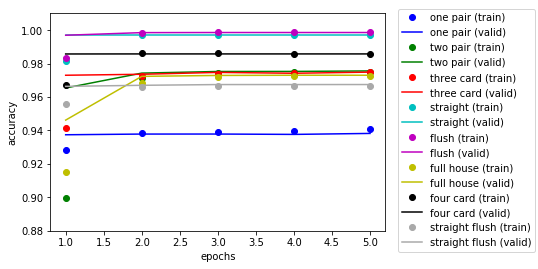

In [162]:
fig = plt.figure()
fig1 = fig.add_subplot(111)

acc = history_one_pair256.history['acc']
val_acc = history_one_pair256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'bo', label='one pair (train)')
fig1.plot(epochs, val_acc, 'b', label='one pair (valid)')


acc = history_two_pair256.history['acc']
val_acc = history_two_pair256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'go', label='two pair (train)')
fig1.plot(epochs, val_acc, 'g', label='two pair (valid)')

acc = history_three256.history['acc']
val_acc = history_three256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'ro', label='three card (train)')
fig1.plot(epochs, val_acc, 'r', label='three card (valid)')

acc = history_straight256.history['acc']
val_acc = history_straight256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'co', label='straight (train)')
fig1.plot(epochs, val_acc, 'c', label='straight (valid)')

acc = history_flush256.history['acc']
val_acc = history_flush256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'mo', label='flush (train)')
fig1.plot(epochs, val_acc, 'm', label='flush (valid)')

acc = history_full256.history['acc']
val_acc = history_full256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'yo', label='full house (train)')
fig1.plot(epochs, val_acc, 'y', label='full house (valid)')

acc = history_four256.history['acc']
val_acc = history_four256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, 'ko', label='four card (train)')
fig1.plot(epochs, val_acc, 'k', label='four card (valid)')

acc = history_sf256.history['acc']
val_acc = history_sf256.history['val_acc']
epochs = range(1, len(acc) + 1)

fig1.plot(epochs, acc, color='darkgray', linewidth=0, marker='o', label='straight flush (train)')
fig1.plot(epochs, val_acc, color='darkgray', label='straight flush (valid)')



fig1.set_ylim(0.88, 1.01)
fig1.set_xlabel('epochs')
fig1.set_ylabel('accuracy')
fig.legend(bbox_to_anchor=(0., 0.43, 1.25, 0.102), loc=5)# anchor（凡例）の第２引数がy、第３引数がx

fig.savefig('draw_pdf/poker256_acc_{}_{}epo.pdf'.format(num_hand, len(acc)))
plt.show()